In [2]:
#Impots
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import os
from model import create_siamese, one_shot
from keras.optimizers import Adam
import numpy as np
from keras import backend as K
from keras.layers import Lambda
from tensorflow.math import scalar_mul as tf_multiply
from tensorflow import convert_to_tensor
import tensorflow as tf

Using TensorFlow backend.


# Fellowship.AI Challenge: One-Shot Learning

Task: Report Results of Model Agnostic Meta-Learning on Omniglot Dataset

# DataSet: Omniglot

Omniglot is a handwritten character recoginition dataset consists of different characters obtained from various world alphabets or languages. Dataset is distributed with 30 alphabets for training and 20 alphabets for validation with
differnt number of characters per alphabet but 20 rendition for each character

In [3]:
#Import Data Set. 
train_path = '../images_background/'
valid_path = '../images_evaluation/'

x_train, train_character_id_list, dict_train = load_imgs(train_path)
x_valid, valid_character_id_list, dict_valid = load_imgs(valid_path)

In [16]:
train_alphabets = list(dict_train.keys())
valid_alphabets = list(dict_valid.keys())
train_alphabets, valid_alphabets

(['Alphabet_of_the_Magi',
  'Anglo-Saxon_Futhorc',
  'Arcadian',
  'Armenian',
  'Asomtavruli_(Georgian)',
  'Balinese',
  'Bengali',
  'Blackfoot_(Canadian_Aboriginal_Syllabics)',
  'Braille',
  'Burmese_(Myanmar)',
  'Cyrillic',
  'Early_Aramaic',
  'Futurama',
  'Grantha',
  'Greek',
  'Gujarati',
  'Hebrew',
  'Inuktitut_(Canadian_Aboriginal_Syllabics)',
  'Japanese_(hiragana)',
  'Japanese_(katakana)',
  'Korean',
  'Latin',
  'Malay_(Jawi_-_Arabic)',
  'Mkhedruli_(Georgian)',
  'N_Ko',
  'Ojibwe_(Canadian_Aboriginal_Syllabics)',
  'Sanskrit',
  'Syriac_(Estrangelo)',
  'Tagalog',
  'Tifinagh'],
 ['Angelic',
  'Atemayar_Qelisayer',
  'Atlantean',
  'Aurek-Besh',
  'Avesta',
  'Ge_ez',
  'Glagolitic',
  'Gurmukhi',
  'Kannada',
  'Keble',
  'Malayalam',
  'Manipuri',
  'Mongolian',
  'Old_Church_Slavonic_(Cyrillic)',
  'Oriya',
  'Sylheti',
  'Syriac_(Serto)',
  'Tengwar',
  'Tibetan',
  'ULOG'])

In [18]:
batch_pairs, batch_target = get_batch_in_pairs(x_train, batch_size=2)

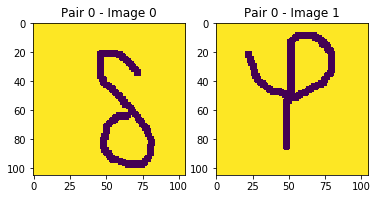

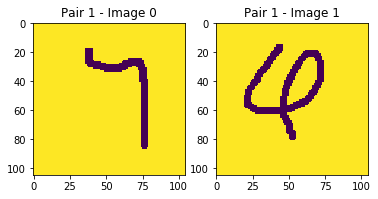

In [20]:
show_batch((batch_pairs, batch_target))

This is an example of available pictures

First I started with the first reported approcah used for classification on omniglot dataset. i.e. 
Human-level concept learning through probbalistic program. This approcah requries an extensive ammount of 
feature enhancement in the initial phase and then learning the task using Bayesian Program Language. In this approach 
the task is subdivided using Baysian Theorem. The most initial level respresentation of the task is created as in 
our case "Strokes" and then these Strokes are used to create Example and those examples are then checked against available data
while maximizing the probablity that a certain character occures with condition that certain strokes were drawn

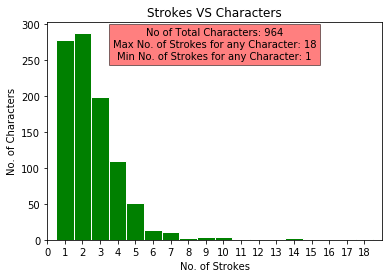

In [21]:
strokes_background_dir = '../strokes_background'

alphabets_lists = os.listdir(strokes_background_dir)

def load_stroke(fn):
	# This function is used from the official demo.py file provided by the omgilot dataset
	motor = []
	with open(fn,'r') as fid:
		lines = fid.readlines()
	lines = [l.strip() for l in lines]
	for myline in lines:
		if myline =='START': # beginning of character
			stk = []
		elif myline =='BREAK': # break between strokes
			stk = np.array(stk)
			motor.append(stk) # add to list of strokes
			stk = [] 
		else:
			arr = np.fromstring(myline,dtype=float,sep=',')
			stk.append(arr)
	return motor

strokes_per_characters = []


for alphabets in alphabets_lists:
	for characters in os.listdir(strokes_background_dir + '/' + alphabets):
		# Load First Rendition in Characters
		first_rendition = os.listdir(strokes_background_dir + '/' + alphabets + '/' + characters)[0]
		strokes_list = load_stroke(strokes_background_dir + '/' + alphabets + '/' + characters + '/' + first_rendition)
		strokes_per_characters.append(len(strokes_list))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(strokes_per_characters, bins=np.arange(np.min(strokes_per_characters) - 0.5, np.max(strokes_per_characters) + 1.5, 1),  histtype='bar', facecolor='g', alpha=1.0, edgecolor='white', linewidth=1.0)
plt.xticks(range(19))
plt.xlim([0, 19])
text = 'No of Total Characters: ' + str(len(strokes_per_characters)) + '\n' +  'Max No. of Strokes for any Character: ' + str(np.max(strokes_per_characters)) + '\n' + 'Min No. of Strokes for any Character: ' + str(np.min(strokes_per_characters))
plt.text(0.5, 0.9, text, ha='center', va='center', transform=ax.transAxes, bbox=dict(facecolor='red', alpha=0.5))
plt.xlabel("No. of Strokes")
plt.ylabel("No. of Characters")
plt.title('Strokes VS Characters')
plt.show()

Below Cell Refernce from Offical Omniglot Visualization 

generating figure 1 of 5
generating figure 2 of 5
generating figure 3 of 5
generating figure 4 of 5
generating figure 5 of 5


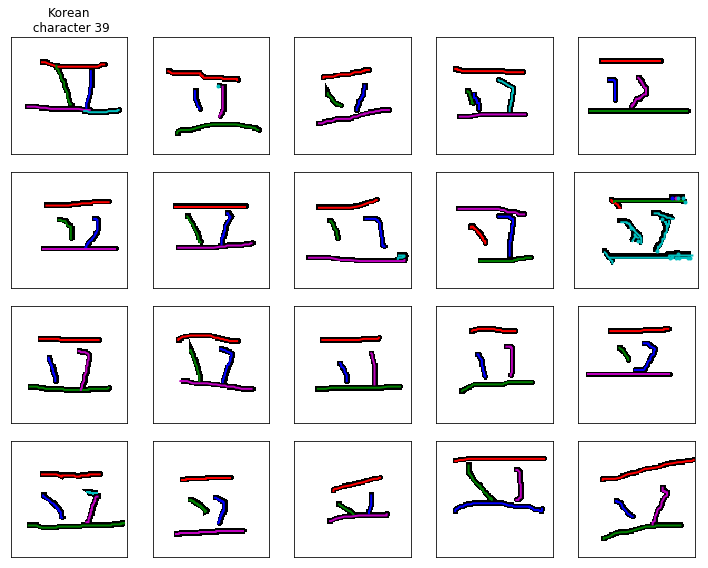

In [24]:
import random
def plot_motor_to_image(I,drawing,lw=2):
	drawing = [d[:,0:2] for d in drawing] # strip off the timing data (third column)
	drawing = [space_motor_to_img(d) for d in drawing] # convert to image space
	plt.imshow(I,cmap='gray')
	ns = len(drawing)
	for sid in range(ns): # for each stroke
		plot_traj(drawing[sid],get_color(sid),lw)
	plt.xticks([])
	plt.yticks([])

# Plot individual stroke
#
# Input
#  stk: [n x 2] individual stroke
#  color: stroke color
#  lw: line width
def plot_traj(stk,color,lw):
	n = stk.shape[0]
	if n > 1:
		plt.plot(stk[:,0],stk[:,1],color=color,linewidth=lw)
	else:
		plt.plot(stk[0,0],stk[0,1],color=color,linewidth=lw,marker='.')

# Color map for the stroke of index k
def get_color(k):	
    scol = ['r','g','b','m','c']
    ncol = len(scol)
    if k < ncol:
       out = scol[k]
    else:
       out = scol[-1]
    return out

# convert to str and add leading zero to single digit numbers
def num2str(idx):
	if idx < 10:
		return '0'+str(idx)
	return str(idx)

# Load binary image for a character
#
# fn : filename
def load_img(fn):
	I = plt.imread(fn)
	I = np.array(I,dtype=bool)
	return I

# Load stroke data for a character from text file
#
# Input
#   fn : filename
#
# Output
#   motor : list of strokes (each is a [n x 3] numpy array)
#      first two columns are coordinates
#	   the last column is the timing data (in milliseconds)
def load_motor(fn):
	motor = []
	with open(fn,'r') as fid:
		lines = fid.readlines()
	lines = [l.strip() for l in lines]
	for myline in lines:
		if myline =='START': # beginning of character
			stk = []
		elif myline =='BREAK': # break between strokes
			stk = np.array(stk)
			motor.append(stk) # add to list of strokes
			stk = [] 
		else:
			arr = np.fromstring(myline,dtype=float,sep=',')
			stk.append(arr)
	return motor

#
# Map from motor space to image space (or vice versa)
#
# Input
#   pt: [n x 2] points (rows) in motor coordinates
#
# Output
#  new_pt: [n x 2] points (rows) in image coordinates
def space_motor_to_img(pt):
	pt[:,1] = -pt[:,1]
	return pt
def space_img_to_motor(pt):
	pt[:,1] = -pt[:,1]
	return

img_dir = '../images_background'
stroke_dir = '../strokes_background'
nreps = 20 # number of renditions for each character
nalpha = 5 # number of alphabets to show

alphabet_names = [a for a in os.listdir(img_dir) if a[0] != '.'] # get folder names
alphabet_names = random.sample(alphabet_names,nalpha) # choose random alphabets

for a in range(nalpha): # for each alphabet
    print('generating figure ' + str(a+1) + ' of ' + str(nalpha))
    alpha_name = alphabet_names[a]

# choose a random character from the alphabet
character_id = random.randint(1,len(os.listdir(os.path.join(img_dir,alpha_name))))

# get image and stroke directories for this character
img_char_dir = os.path.join(img_dir,alpha_name,'character'+num2str(character_id))
stroke_char_dir = os.path.join(stroke_dir,alpha_name,'character'+num2str(character_id))

# get base file name for this character
fn_example = os.listdir(img_char_dir)[0]
fn_base = fn_example[:fn_example.find('_')] 

plt.figure(a,figsize=(10,8))
plt.clf()
for r in range(1,nreps+1): # for each rendition
    plt.subplot(4,5,r)
    fn_stk = stroke_char_dir + '/' + fn_base + '_' + num2str(r) + '.txt'
    fn_img = img_char_dir + '/' + fn_base + '_' + num2str(r) + '.png'			
    motor = load_motor(fn_stk)
    I = load_img(fn_img)
    plot_motor_to_image(I,motor)
    if r==1:
        plt.title(alpha_name[:15] + '\n character ' + str(character_id))
plt.tight_layout()
plt.show()

The above figure shows the character developement wrt to differnt strokes. As this Method is very much task specific and there have been much more 
advanced techniques for classification of this task, So I opted to them. The Next Approach I took was inspired from 
"Siamese Neural Networks for One Shot Image Recognition by Gregory Koch, Richard Zemel and Rusian Salakhutdinov"

In [6]:
# Implementation of the Paper
# Creating Model
siamese_model = create_siamese(input_size=(105, 105, 1))
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
siamese_model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer)

siamese_model.metrics_names.append("gradient_norm")
siamese_model.metrics_tensors.append(gradient_norm(siamese_model))

#Initializing Parameters
max_iterations = 200
one_shot_check = 5
history = []
validation_accuracy = []
# Training Model 
for i in np.arange(0, max_iterations):
    batch_pairs, batch_targets = get_batch_in_pairs(x_train, batch_size=32)
    epoch_data= siamese_model.train_on_batch(batch_pairs, batch_targets)
    history.append(epoch_data)
    if i % one_shot_check == 0:
        print("Checking One-Shot Validation")
        val_accuracy = one_shot(x_valid, siamese_model, e_times=10, n_way=20)
        validation_accuracy.append(val_accuracy)

Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-Shot Validation
Checking One-S

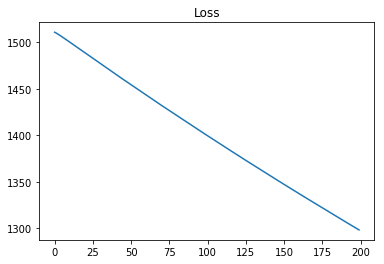

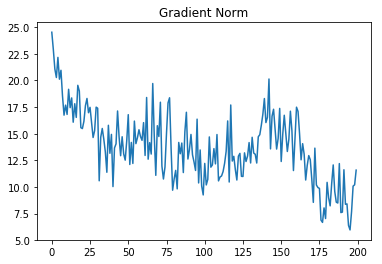

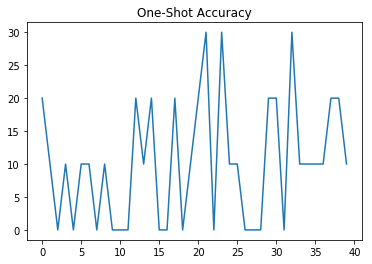

In [7]:
history = np.array(history)
plt.figure()
plt.title("Loss")
plt.plot(history[:, 0])
plt.figure()
plt.title("Gradient Norm")
plt.plot(history[:, 1])
plt.figure()
plt.title("One-Shot Accuracy")
plt.plot(validation_accuracy)


After getting results on the above research paper. I Started with implementing the MAML technqiue on training the network.

In [4]:
siamese_model = create_siamese(input_size=(105, 105, 1))
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

siamese_model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer)

siamese_model.metrics_names.append("gradient_norm")
siamese_model.metrics_tensors.append(gradient_norm(siamese_model))

test_model = create_siamese((105, 105, 1))
test_model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer)

alpha = 0.01
beta = 0.01
batch_pairs_meta_update = []
batch_targets_meta_update = []
theta_prime_list = []
meta_gradient_epochs = 1
max_iterations = 20
one_shot_check = 5
history = []

for i in np.arange(0, max_iterations):
    print('Running Epoch: ', i)
    batch_pairs, batch_targets = get_batch_in_pairs(x_train, batch_size=2)
    batch_targets = batch_targets.reshape(2, 1)

    loss_function = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=batch_targets.reshape(2, 1).astype(np.float32), logits=siamese_model.output))
    #loss_function = (tf.nn.sigmoid_cross_entropy_with_logits(labels=batch_targets.reshape(2, 1).astype(np.float32), logits=np.array(prediction).reshape(2, 1).astype(np.float32)))
    #loss_function = tf.reduce_mean(tf.square(np.array(siamese_model.output).reshape(2, 1).astype(np.float32)-batch_targets.reshape(2, 1).astype(np.float32)))
    #loss_function = binary_crossentropy(convert_to_tensor(batch_targets, dtype=tf.float32), convert_to_tensor(prediction , dtype=tf.float32))

    train_parameter = siamese_model.trainable_weights
    calculate_gradients = K.gradients(loss_function, train_parameter)

    K.get_session().run(tf.initialize_all_variables())
    gradient_values = K.get_session().run(calculate_gradients, feed_dict={'input_1:0':batch_pairs[0], 'input_2:0':batch_pairs[1]})

    theta_prime = [weight - (alpha * gradient) for weight, gradient in
                   zip(siamese_model.get_weights(), gradient_values)]

    theta_prime_list.append(theta_prime)

    batch_pairs_temp, batch_targets_temp = get_batch_in_pairs(x_train, batch_size=2)
    batch_pairs_meta_update.append(batch_pairs_temp)
    batch_targets_meta_update.append(batch_targets_temp)

    for j in np.arange(0, meta_gradient_epochs):
        update_sum = 0
        for idx, (theta_prime, batch_pairs, batch_targets) in enumerate(
                zip(theta_prime_list, batch_pairs_meta_update, batch_targets_meta_update)):
            test_model.set_weights(theta_prime)
            loss_function = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(labels=batch_targets.reshape(2, 1).astype(np.float32),
                                                        logits=test_model.output))
            train_parameter = test_model.trainable_weights
            calculate_gradients = K.gradients(loss_function, train_parameter)
            K.get_session().run(tf.initialize_all_variables())
            gradient_values = K.get_session().run(calculate_gradients,
                                                  feed_dict={'input_3:0': batch_pairs[0], 'input_4:0': batch_pairs[1]})
            theta = [weight - (beta * gradient) for weight, gradient in
                           zip(siamese_model.get_weights(), gradient_values)]
            siamese_model.set_weights(theta)

    if i % one_shot_check == 0:
        val_accuracy = one_shot(x_valid, siamese_model, e_times=1, n_way=5)
        history.append(val_accuracy)

Running Epoch:  0
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Running Epoch:  1
Running Epoch:  2
Running Epoch:  3
Running Epoch:  4
Running Epoch:  5
Running Epoch:  6
Running Epoch:  7
Running Epoch:  8
Running Epoch:  9
Running Epoch:  10
Running Epoch:  11
Running Epoch:  12
Running Epoch:  13
Running Epoch:  14
Running Epoch:  15
Running Epoch:  16
Running Epoch:  17
Running Epoch:  18
Running Epoch:  19


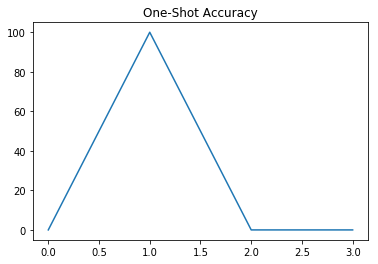

In [7]:
plt.figure()
plt.title("One-Shot Accuracy")
plt.plot(history)

There are two different techniques used in this notebook to train one-shot learning task on omiglot dataset. The First technique is the use
of Siamese Network. The results produced are not compareable to the original paper because of reasons such as Learning Rate Scheduling, 
Augmentation of dataset. The accuracy reported in the original paper is 92 percent of Convolutional Siamese Network. We can see that the valdiation accuracy 
is not smooth which suggests it requires hyperparameter optimization. Also , gradient norm shows our gradient updates are good. 
The second implementation is of maml. As per my knowledge its first implementation of MAML on Keras-API. The paper suggest 
that the results should be more promising than normal Convolutionl Siamese Nets. The results cannot be analyzed in depth beccause of 
computational limitations

